# Tarea 6: Integración con Taylor

Fecha de envío del PR inicial: **viernes 5 de mayo**

Fecha de aceptación del PR: **martes 16 de mayo, antes de la clase**

---

## Ejercicio 1

Usando su implementación de polinomios de Taylor, escriban un integrador para la ecuación diferencial que se desarrolló en este ejemplo, esto es, $\dot{x} = x^2$ con la condición inicial $x(0) = 3$. 

El integrador debe hacer las operaciones necesarias para obtener automáticamente los coeficientes $x_{[k]}$, *en cada paso de integración*, a partir de la condición inicial local. Un requisito básico para esto es que tengan una implementación de la función $P_\alpha(x) = [g(x)]^\alpha$ con $g(x)$ un polinomio de Taylor, que hicieron en la "Tarea5", y que funcione bien en particular para `alpha::Int`.

La implementación debe consistir de varias funciones: 

1. Una función donde se calculen los coeficientes $x_{[k]}$ de la expansión. Esta función deberá llamar a otra donde se implementan las recurrencias que imponen las ecuaciones de movimiento.

2. Una función donde se obtenga el paso de integración $h$ como se describió en el notebook 10.

- Otra función donde se haga la suma usando el método de Horner.

- Finalmente, una función que combine las funciones anteriores para hacer la integración desde un tiempo inicial a uno final. En este punto, *fingiremos ignorancia*, en el sentido de  que el tiempo inicial es cero, y el tiempo final será $0.5$ (que está más allá de donde la solución está definida).


Dado que conocemos la solución analítica de este problema, grafiquen como función de $t$ el error relativo de su integrador (respecto al valor del resultado analítico).

In [1]:
include("Taylor.jl")
using ADT
using PyPlot

1. Utilizando que 

\begin{equation}
x_{[k]} = \frac{f_{[k-1]}}{k},
\end{equation}
   podemos definir una funcion que encuentre de manera iterativa los coeficientes de $x(t)$

In [2]:
function coeficient(x0::Number, f::Function, n = 30)
    ## n fue escogido de manera arbitraria, 30 parece un buen numero
    a = [x0]
    
    for k = 1:(n - 1) ## usar n - 1 nos deja con un polinomio de grado n ya que se utiliza el valor de x0
        iter = f(Taylor(a))
        push!(a, iter.coef[k]/(k))
    end
    
    return Taylor(a)
end

coeficient (generic function with 2 methods)

In [3]:
x_t = coeficient(3.0, x -> x^2)

ADT.Taylor{Float64}([3.0,9.0,27.0,81.0,243.0,729.0,2187.0,6561.0,19683.0,59049.0  …  1.04604e10,3.13811e10,9.41432e10,2.8243e11,8.47289e11,2.54187e12,7.6256e12,2.28768e13,6.86304e13,2.05891e14])

Como vemos la solucion cumple con lo obtenido analiticamente, esto es
$x_0 = 3^1$, $x_1 = 3^2$, $x_2 = 3^3$, ... , $x_n = 3^{n+1}$, 

Ahora necesitamos una funcion que determine el paso de integracion adaptativo

Utilizamos

\begin{equation}
h = t-t_0 \leq \Big(\frac{\epsilon}{\big| x_{[p]}(t_0)\big|}\Big)^{1/p}.
\end{equation}

Condicion que brinda la convergencia de la serie de potencia $p$

In [4]:
function adaptive_step(a::Taylor, epsi = 1e-30)
    p = gradomax(a)
    while p != 0 && a.coef[p] == 0 ## Asi utilizamos el ultimo termino no nulo
        p -= 1
    end
    h = 0.5 * (epsi / abs(a.coef[p]))^(1/p) ## Multiplicar por 0.5 nos garantiza que es menor que la cota
    return h
end

adaptive_step (generic function with 2 methods)

In [5]:
adaptive_step(x_t)

0.016666666666666666

Ahora definimos una funcion que utilice el metodo de Horner para valuar el polinomio.

In [6]:
function horner_evaluation(a::Taylor, x0::Number)
    n = gradomax(a)
    y = a.coef[n]
    
    for i = 1:(n - 1)
        y = a.coef[n - i] + y * x0
    end
    
    return y
end

horner_evaluation (generic function with 1 method)

Por ultimo definimos una funcion que combina las funciones anteriores de manera que haga la integracion de un tiempo $t_0$ a un $t_f$

In [7]:
function integradorT(f::Function, t0::Number, tf::Number, x0::Number)
    
    max = 1000 ## Iteraciones maximas del while
    
    tiempos = [t0]
    solucion = [x0]
    
    n = 0 ## Contador

    while t0 < tf && isnan(x0) == false && n < max  ## el isnan() nos ayuda a parar la integracion al pasar por nu punto singular
        
        sol = coeficient(x0, f)
        h = adaptive_step(sol)
        
        t0 += h
        
        x0 = horner_evaluation(sol, h)
        
        push!(tiempos, t0)
        push!(solucion, x0)
        n += 1
        
    end
    
    return tiempos, solucion
end

integradorT (generic function with 1 method)

Probamos el integrador con el ejemplo

In [8]:
ẋ(x) = x^2
f(x) = 3.0 / (1.0 - 3.0 * x) ## Solucion analitica

f (generic function with 1 method)

In [9]:
t, y = integradorT(ẋ, 0.0, 0.5, 3.0);

In [17]:
F = map(f, t);

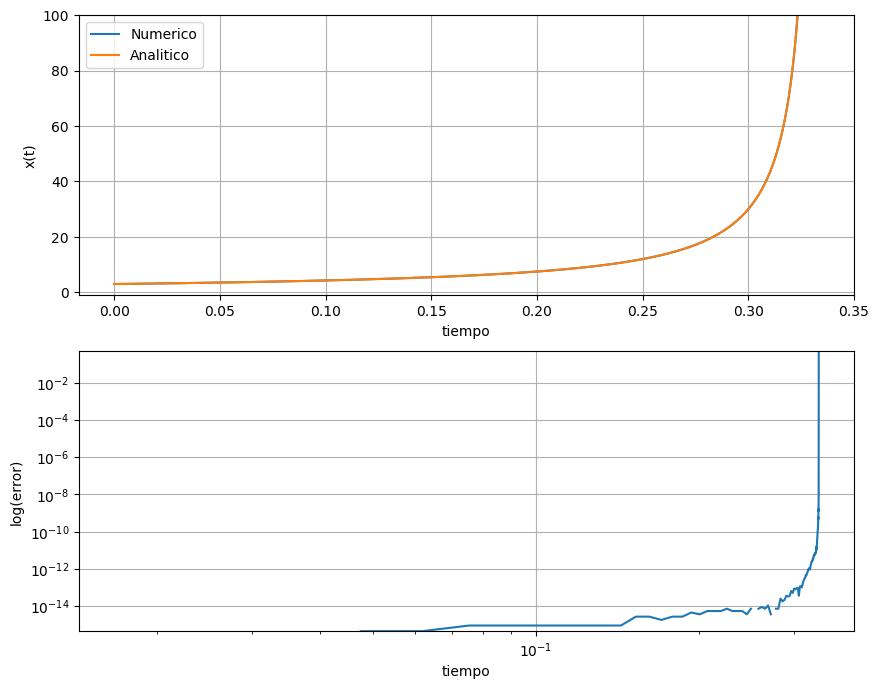

PyObject <matplotlib.text.Text object at 0x7f7e7f8bee80>

In [45]:
fig = figure(figsize = (10, 8))

ax = subplot(211); bx = subplot(212)

ax[:plot](t, y, label  = "Numerico")
ax[:plot](t, map(f, t), label = "Analitico")
ax[:set_ylim](-1, 100)

err = abs(F - y)
bx[:loglog](t, err)
bx[:grid]()
bx[:set_ylim](0, 0.5)

ax[:legend](); ax[:grid]()
ax[:set_xlabel]("tiempo"); ax[:set_ylabel]("x(t)")
bx[:set_xlabel]("tiempo"); bx[:set_ylabel]("log(error)")

Podemos ver que el error en el calculo se vuelve grande al acercarnos a la singularidad en $t = \frac{1}{3}$

---

## Ejercicio 2

Repitan la integración del ejercicio anterior usando el método de Runge-Kutta de 4o orden con paso de integración fijo (que es lo más sofisticado que conocen hasta ahora) y comparen los resultados del error relativo con los obtenidos con el método de Taylor. En particular, finjan ignorancia de la misma manera que en el ejercicio anterior.

---

## Ejercicio 3

Integra la ecuación de movimiento para el oscilador armónico, $\ddot{x} = -2x$, con $x(0)=2$, $\dot{x}(0)=0$, durante 10^4 periodos de oscilación (o sea, hasta $t_f = 10^4 \cdot 2\pi/\sqrt{2}$, usando el método de Taylor y el método de Runge-Kutta de 4o orden con paso de integración constante. Compara cómo cambia la energía (respecto al valor al tiempo cero) en función del tiempo en ambos métodos.